In [10]:
import numpy as np

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

import shapely
from shapely.geometry import Polygon
# from shapely.geometry import Point
# from shapely.geometry import LineString

# from descartes import PolygonPatch


# Import Rudimentary Shape File

In [2]:
Nhoods = gpd.read_file('Neighbourhoods.shp')
#Nhoods.crs
Nhoods = gpd.GeoDataFrame(Nhoods,geometry='geometry',crs={'init':'epsg:4326'})

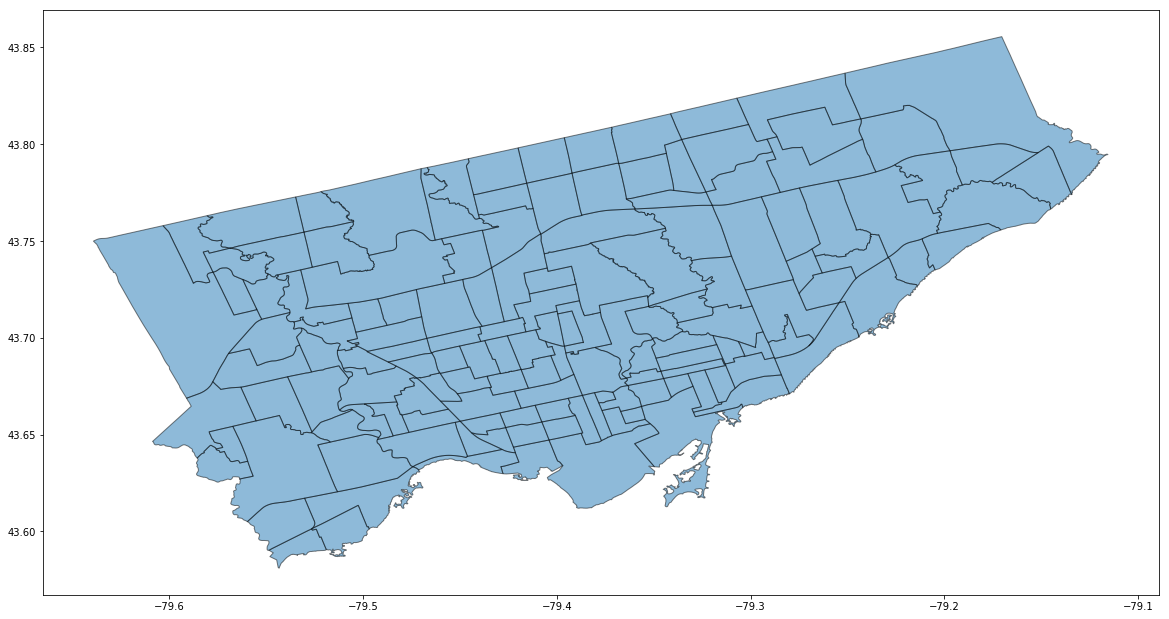

In [3]:
Nhoods.plot(alpha=0.5,figsize=(20,60),edgecolor='black')

# Extract Toronto's Boundary 

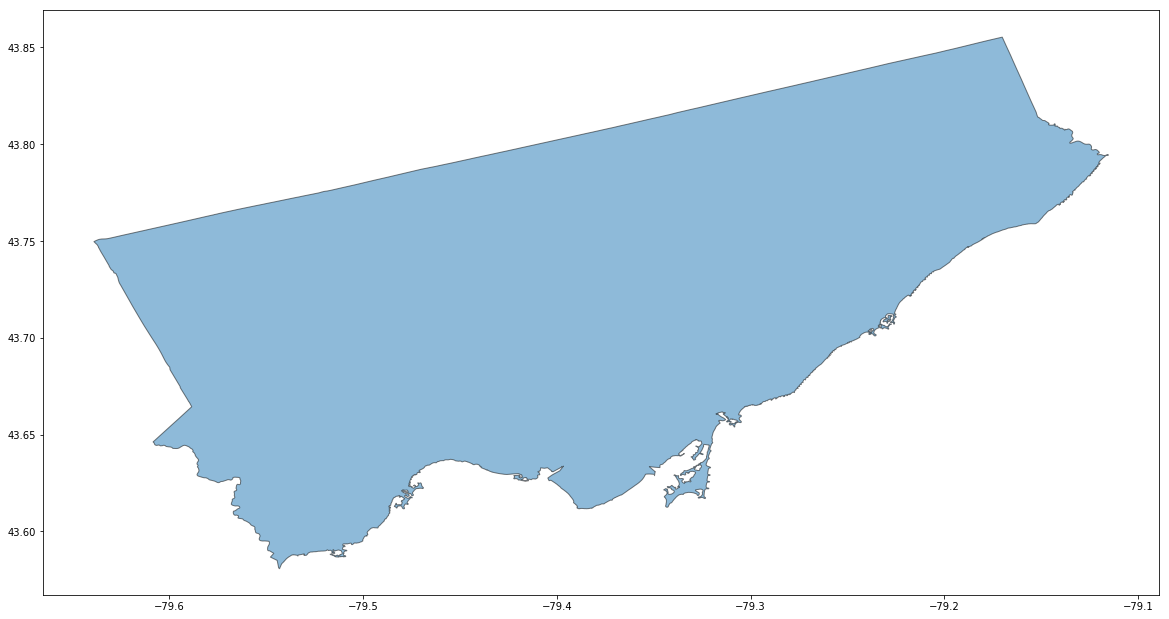

In [4]:
TO_boundary = Nhoods.dissolve(by='FIELD_4')
TO_boundary = TO_boundary[['geometry']]
TO_boundary.plot(alpha=0.5,edgecolor='black',figsize=(20,60))

# Make Measurements on Map

In [30]:
def haversine(coord1, coord2):
    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2
    R = 6371000  # radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)

    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters)
    km = round(km, 3)
    #print(f"Distance: {meters} m")
    #print(f"Distance: {km} km")
    return meters


In [27]:
xmin,ymin,xmax,ymax = Nhoods.total_bounds

In [31]:
print('E-W length of Toronto = ' + str(haversine((xmin,ymin),(xmax,ymin))) + ' metres')
print('N-S length of Toronto = ' + str(haversine((xmin,ymin),(xmin,ymax))) + ' metres') 

E-W length of Toronto = 42193.0 metres
N-S length of Toronto = 30519.0 metres


In [32]:
#E-W extent of Toronto = 42193 metres
EW = haversine((xmin,ymin),(xmax,ymin))
# N-S extent of Toronto = 30519 metres
NS = haversine((xmin,ymin),(xmin,ymax))
# diamter of each hexagon in the grid = 900 metres
d = 900 
# horizontal width of hexagon = w = d* sin(60)
w = d*np.sin(np.pi/3)
# Approximate number of hexagons per row = EW extent of Toronto / Width of Hexagon = EW/w 
n_cols = int(EW/w)+1
# Approximate number of hexagons per column
n_rows = int(((NS/d)-1)*(4/3))+1 #I think this is the right formula

# Make Hexagonal Grid Covering Entire Extent of Map

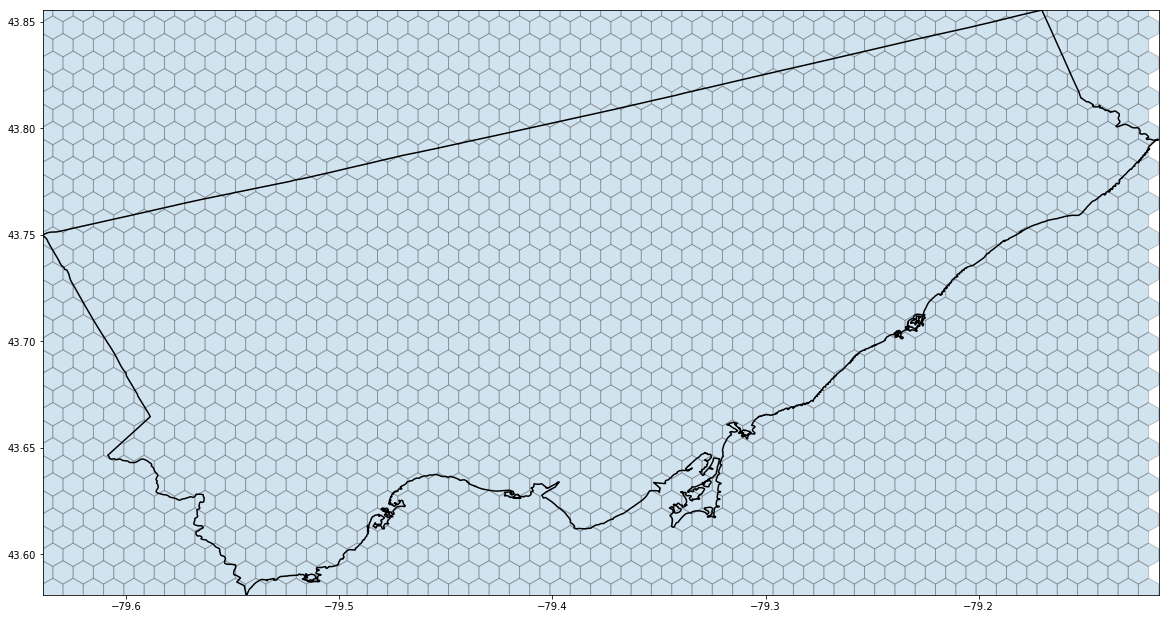

In [37]:
from matplotlib.patches import RegularPolygon
import numpy as np
ax = TO_boundary.boundary.plot(edgecolor='black',figsize=(20,60))

w = (xmax-xmin)/n_cols # width of hexagon
d = w/np.sin(np.pi/3) #diameter of hexagon
o = 0.5 * np.tan(np.pi/3)  # orientation of polygon

array_of_hexes = []
for rows in range(0,34):
    hcoord = np.arange(xmin,xmax,w) + (rows%2)*w/2
    vcoord = [ymax- rows*d*0.75]*n_cols
    for x, y in zip(hcoord, vcoord):#, colors):
        hexes = RegularPolygon((x, y), numVertices=6, radius=d/2, alpha=0.2, edgecolor='k')
        verts = hexes.get_path().vertices
        trans = hexes.get_patch_transform()
        points = trans.transform(verts)
        array_of_hexes.append(Polygon(points))
        ax.add_patch(hexes)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

# Convert Hex Grid into GeoDataFrame

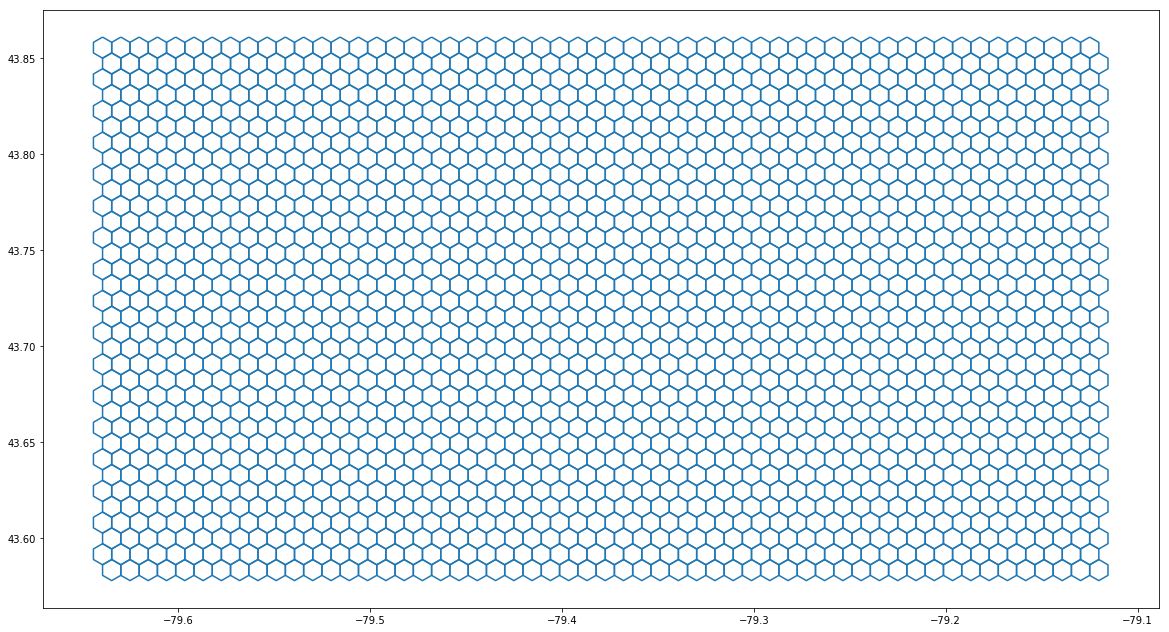

In [12]:
hex_grid = gpd.GeoDataFrame({'geometry':array_of_hexes},crs={'init':'epsg:4326'})
hex_grid.boundary.plot(figsize=(20,60))

# Overlay Hex Grid and Toronto Map

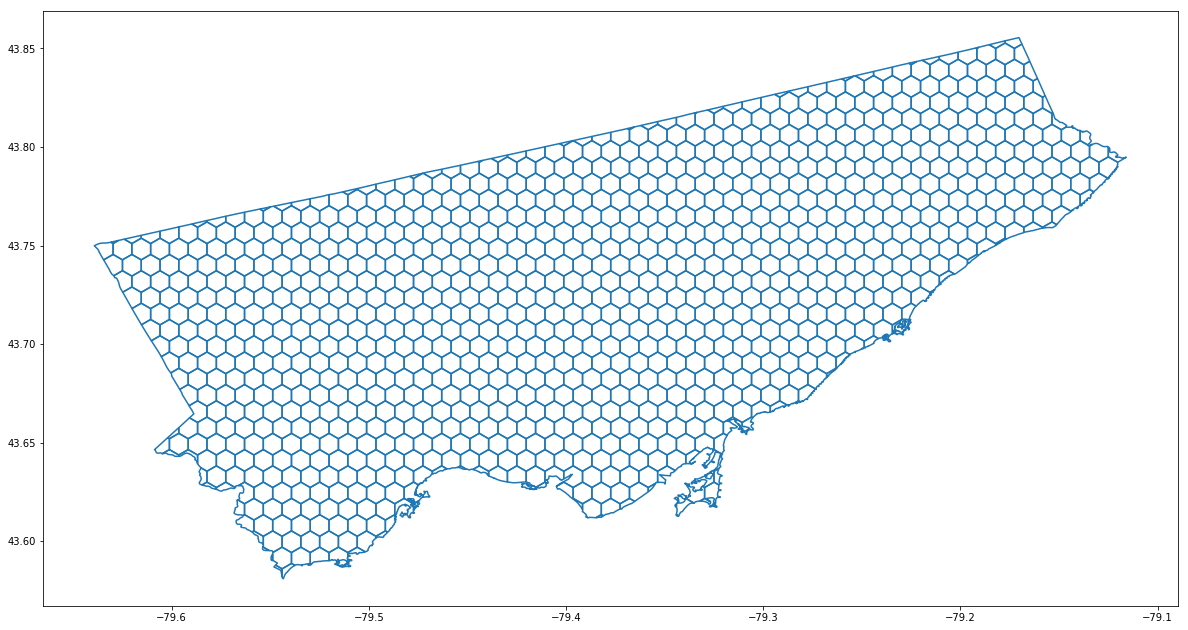

In [13]:
TO_hex = gpd.overlay(hex_grid,TO_boundary)
TO_hex = gpd.GeoDataFrame(TO_hex,geometry='geometry')
TO_hex.boundary.plot(figsize=(D/1500,W/1500))

# Export Toronto's Hex Grid as Shape File

In [ ]:
#TO_hex.to_file(TO_hex.shp")